# Perspektiva obrazu - kartézský a polární souřadný systém
Cvičení je zaměřené na práci s polárními souřadnicemi při využití nestandardních 360° objektivů od firmy [Opto Engineering](https://www.opto-e.com/). Způsob použití takových objektivů je demonstrován v [tutoriálu](https://www.opto-e.com/resources/peripheric-optics-tutorial) na stránkách výrobce. Jedná o následující optické systémy:

## Optické systémy
Pericentrický objektiv | <img src="https://www.opto-e.com/media/pc/pc_main.jpg" width="45%"> | Boroskopická sonda | <img src="https://www.opto-e.com/media/pcbp/pcbp_main.jpg" width="45%">
-|-|-|-

[Pericentrický objektiv](https://www.opto-e.com/products/pericentric-lenses#Media) umožňuje podívat se nejen na vršek objektu, ale dokonce i na jeho strany zároveň. Typickými aplikacemi jsou například kontrola potisků víček či kontrola defektů [hrdel lahví](https://www.visiononline.org/vision-resources-details.cfm/vision-resources/Wine-Bottle-Vision-Inspection-System/content_id/6450).

[Boroskopická sonda](https://www.opto-e.com/products/boroscopic-probes#Overview) díky zrcadlu umožnuje podívat se 360 ° dokola kolem sebe. Typickými aplikacemi jsou průmyslové inspekce děr či kontroly správnosti závitů. 

## Souřadné systémy
Potřebnou prerekvizitou je znalost existence **kartézského** a **polárního** souřadného systému a tedy dvojí možnosti zápisu souřadnic. Pěkně je to vysvětleno například na webu [Math is fun](https://www.mathsisfun.com/polar-cartesian-coordinates.html).

Proč budeme tuto znalost potřebovat je jasné ve chvíli, když si zobrazíte ukázky obrázků získaných jednotlivými optickými systémy.

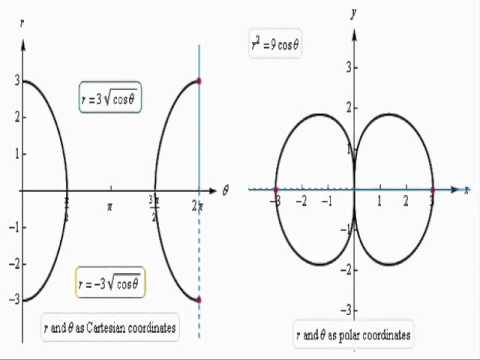

In [1]:
# Youtube video s ukázkami funkcí v kartézských a polárních souřadnicích
from IPython.display import Audio, Image, YouTubeVideo
YouTubeVideo(id='Uros5bufLJI', width=600, height=300)

---

### Import knihoven a konfigurace

In [2]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import cv2
from pypylon import pylon 
from IPython.display import clear_output, display

import pytesseract
from PIL import Image

%matplotlib inline

### Pomocné funkce
Z následujících funkcí je potřeba vybírat ty vhodné pro splnění úkolu.

<a id='connect_functions'>Funkce k připojení kamery.</a>

In [3]:
# List of camera features to create widgets
FEATURES = [
    {
        "name": "Gain",
        "type": "int"
    },
    {
        "name": "ExposureTime",
        "type": "int",
        "max": 35000,
        "min": 90,
        "step": 30,
        "value": 1500
    },
    #     {
    #         "name": "Height",
    #         "type": "int_text",
    #         "max": 2000,
    #         "min": 100,
    #         "step": "1",
    #         'value':1270
    #     },
    #     {
    #         "name": "Width",
    #         "type": "int_text",
    #         "max": 2000,
    #         "min": 100,
    #         "step": "1",
    #         'value':1344
    #     },
    #     {
    #         "name": "OffsetX",
    #         "type": "int_text",
    #         "max": 1000,
    #         "min": 0,
    #         "step": "1",
    #         'value':608
    #     },
    #     {
    #         "name": "OffsetY",
    #         "type": "int_text",
    #         "max": 1000,
    #         "min": 0,
    #         "step": "1",
    #         'value':418
    #     }
]

In [4]:
def connect_camera(serial_number):
    ''' Connects camera specified with its serial number
    
    Parameters
    ----------
    serial_number : string
        Camera's serial number.
    grabbed_images_path : string
        Path to folder where the saved images will be stored.
    Returns
    -------
    camera : object
    '''
    info = None
    for i in pylon.TlFactory.GetInstance().EnumerateDevices():
        if i.GetSerialNumber() == serial_number:
            info = i
            break
    else:
        print('Camera with {} serial number not found'.format(serial_number))

    # VERY IMPORTANT STEP! To use Basler PyPylon OpenCV viewer you have to call .Open() method on you camera
    if info is not None:
        camera = pylon.InstantCamera(pylon.TlFactory.GetInstance().CreateDevice(info)) 
        camera.Open()
        return camera
    else:
        return None    

Funkce pro zobrazení okna s přidáním eventu na klik myší.

In [5]:
def show_camera_window(*imgs, scale=1):
    def print_xy(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONUP:
            print('x = %d, y = %d'% (x, y))  
        
    for i, img in enumerate(imgs, 1):
        window_name = 'Camera capture (' + serial_number + ')'
        
        h,w = img.shape[:2]
        window_name_id = window_name + ' ' + str(i)
        cv2.namedWindow(window_name_id, cv2.WINDOW_NORMAL | cv2.WINDOW_GUI_NORMAL)
        cv2.resizeWindow(window_name_id, int(w * scale), int(h * scale))
        cv2.setMouseCallback(window_name_id, print_xy)
        cv2.moveWindow(window_name_id, (i-1)*int(w * scale), 0)
        cv2.imshow(window_name_id, img)

<a id='preprocessing_functions'>Metody předzpracování.</a>

In [6]:
def to_gray(img):
    ''' Converts image to monochrome
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    Returns
    -------
    Ouput image.
    '''
    if len(img.shape) == 2:
        return img
    return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)

def to_hsv(img):
    ''' Converts image to HSV (hue, saturation, value) color space.
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    Returns
    -------
    Ouput image.
    '''
    dst = cv2.cvtColor(img, cv2.COLOR_BGR2HSV)
    return dst

def negative(img):
    ''' Converts image to its negative
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    Returns
    -------
    Ouput image.
    '''
    dst = 255 - img
    return dst

def crop(img, tl_x, tl_y, br_x, br_y):
    ''' Crops image by added coordinates
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    tl_x : int
        TOP-LEFT corner's x-coordinate
    tl_y : int
        TOP-LEFT corner's y-coordinate
    br_x : int
        BOTTOM-RIGHT corner's x-coordinate
    br_y : int
        BOTTOM-RIGHT corner's y-coordinate
    Returns
    -------
    Ouput image.
    '''
    roi = img[tl_y:br_y, tl_x:br_x]
    return roi    

<a id='segmentation_functions'>Metody segmentace.</a>

In [7]:
def segmentation_one_threshold(img, threshold):
    '''Segments image into black & white using one threshold
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    threshold : int
        Pixels with value lower than threshold are considered black, the others white.
    Returns
    -------
    Ouput image.
    '''
    _, dst = cv2.threshold(img, threshold, 255, cv2.THRESH_BINARY)
    return dst

def segmentation_auto_threshold(img):
    '''Segments image into black & white using automatic threshold
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    Returns
    -------
    Ouput image.
    '''
    _, dst = cv2.threshold(img, 0, 255, cv2.THRESH_BINARY+cv2.THRESH_OTSU)
    return dst

def segmentation_two_thresholds(img, lower, higher):
    '''Segments image into black & white using two thresholds
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    lower : int
        Pixels with value lower than threshold are considered black, the others white.
    higher : int
        Pixels with value higher than threshold are considered black, the others white.
    Returns
    -------
    Ouput image.
    '''
    return cv2.inRange(img, min(lower, higher), max(lower, higher))

def segmentation_adaptive_threshold(img, size, constant=0):
    '''Segments image into black & white using calculated adaptive 
    threshold using Gaussian function in pixel neighbourhood.
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    size : int
        Size of used gaussian. Lowest value is 3. Algorithm uses only odd numbers.
    constant : int
        Value that is added to calculated threshlod. It could be negative as well as zero as well as positive number.
    Returns
    -------
    Ouput binary image.
    '''
    if size < 3:
        size = 3
    elif size % 2 == 0:
        size -= 1
    return cv2.adaptiveThreshold(img, 255, cv2.ADAPTIVE_THRESH_GAUSSIAN_C, cv2.THRESH_BINARY, size, int(constant))

def contours(img_bin, area=0):
    '''Finds contours in binary image and filters them using their area. Then it draws binary image
    from filtered contours. It counts contours as well.
    
    Parameters
    ----------
    img_bin : numpy.ndarray
        Input binary image.
    area : int
        Size of contour that is used to filter all smaller contours out.
    Returns
    -------
    contour_drawn : numpy.ndarray
        Output binary image with drawn filled filtered contours.
    count : int
        Number of found and filtered contours.
    '''
    _, contours, _  = cv2.findContours(img_bin, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    contours =  [c for c in contours if cv2.contourArea(c) > area]
    contour_drawn = cv2.drawContours(np.zeros(img_bin.shape, dtype=np.uint8), contours, -1, color=(255, 255, 255), thickness=cv2.FILLED)
    return contour_drawn, len(contours)    

<a id='filtration_functions'>Metody filtrace.</a>

In [8]:
def filtration_median(img, filter_size):
    '''Filters image noise using median algorithm
    
    Parameters
    ----------
    img : numpy.ndarray
        Input image.
    filter_size : int
        Size of median filter.
    Returns
    -------
    Ouput image.
    '''
    return cv2.medianBlur(img, filter_size)   

def fill_holes(img_bin, close=False, size=5):
    '''Fill holes in found contours. It could merge the contour using close input with appropriate size.
    
    Parameters
    ----------
    img_bin : numpy.ndarray
        Input binary image.
    close : boolean
        If it should merge contours with missing points using close operation.
    size : int
        Size of close operation element.
    Returns
    -------
    Ouput binary image.
    '''
    if close:
        struct = cv2.getStructuringElement(cv2.MORPH_ELLIPSE, (size, size))
        img_bin = cv2.morphologyEx(img_bin, cv2.MORPH_CLOSE, struct)
    res, _ = contours(img_bin)
    return res

<a id='show_functions'>Metoda pro zobrazení různého množství obrázků.</a>

In [24]:
def show_images(*imgs, scale=1, window_name='Image preview'):
    """ Opens multiple image previews depending on the length of the input *imgs list.
    The preview is terminated by pressing the 'q' key.
    
    Parameters
    ----------
    *imgs : list
        Multiple input images which have to be shown.
    scale : double
        Scale of shown image window.
    window_name : Optional[string]
        An optional window name.
    Returns
    -------
    None
    """
    def print_xy(event, x, y, flags, param):
        if event == cv2.EVENT_LBUTTONUP:
            print('x = %d, y = %d'% (x, y))        
    
    for i, img in enumerate(imgs, 1):
        h,w = img.shape[:2]
        window_name_id = window_name + ' ' + str(i)
        cv2.namedWindow(window_name_id, cv2.WINDOW_NORMAL | cv2.WINDOW_GUI_NORMAL)
        cv2.resizeWindow(window_name_id, int(w * scale), int(h * scale))
        cv2.setMouseCallback(window_name_id, print_xy)
        cv2.moveWindow(window_name_id, (i-1)*int(w * scale), 0)

    while 1:
        for i, img in enumerate(imgs, 1):
            cv2.imshow(window_name + ' ' + str(i), img)
            
        k = cv2.waitKey(0)
        
        if k == ord('q') or k == 27:
            break

    cv2.destroyAllWindows()
    
def plot_images(*imgs):
    f = plt.figure(figsize=(10,5))
    for i, img in enumerate(imgs, 1):
        ax = f.add_subplot(1, len(imgs), i)
        ax.imshow(img)

<a id='ocr'>Metoda pro OCR obrazu</a>

In [10]:
def ocr(img_bin):
    '''Detects text in the file.
    
    Parameters
    ----------
    img_bin : numpy.ndarray
        Input binary image. White objects on black background.
    Returns
    -------
    Text on image.
    '''
    # Tesseract works with black objects on white background.
    img_bin = negative(img_bin)
    return pytesseract.image_to_string(Image.fromarray(img_bin))

<a id='others'>Metody ostatní</a>

In [11]:
def to_intensity(hue_angle):
    '''Converts color angle in HUE definition into intensity value of brightness image in opencv
    
    Parameters
    ----------
    hue_angle : int
        Angle in HUE definition.
    Returns
    -------
    Integer value that represents the same HUE value but in opencv brightness image.
    '''
    return int(hue_angle * 0.5)

<a id='cart_polar_functions'>Metody transformací</a>. Například převodu mezi kartézskými a polárními souřadnicemi nebo rotace.

In [12]:
# Linear polar warp help function
def polar_warp(img, full_radius=True, inverse=False):
    center = (img.shape[0]/2.0, img.shape[1]/2.0)
    
    if full_radius:
        radius = np.sqrt(((img.shape[0]/2.0)**2.0)+((img.shape[1]/2.0)**2.0))
    else:
        radius = center[0]
    
    method = cv2.WARP_FILL_OUTLIERS
    if inverse: 
        method += cv2.WARP_INVERSE_MAP
    dest = cv2.linearPolar(img, center, radius, method)
    return dest

In [13]:
def warp_to_cartesian(img, full_radius=True):
    return polar_warp(img, full_radius)

def warp_to_polar(img, full_radius=True):
    return polar_warp(img, full_radius, True)

def rotate(img, angle):
    height, width = img.shape[:2]
    image_center = (width/2, height/2)

    rotation_mat = cv2.getRotationMatrix2D(image_center, angle, 1.)

    abs_cos = abs(rotation_mat[0,0])
    abs_sin = abs(rotation_mat[0,1])

    bound_w = int(height * abs_sin + width * abs_cos)
    bound_h = int(height * abs_cos + width * abs_sin)

    rotation_mat[0, 2] += bound_w/2 - image_center[0]
    rotation_mat[1, 2] += bound_h/2 - image_center[1]

    dest = cv2.warpAffine(img, rotation_mat, (bound_w, bound_h))
    return dest

Metody na tvorbu umělých obrázků

In [14]:
def artificial_circle_image(size):
    img_art_circ = np.ndarray((size, size), dtype=np.float32)
    step = 10
    for i in range(step, size, step):
        cv2.circle(img_art_circ, (int(size/2.0), int(size/2.0)), i-step, np.random.randint(0,255), thickness=4)
    return img_art_circ

---

Seznam funkcí pro přehlednost:
- [`connect_camera(...)`](#connect_functions)
- [`show_images(...)`](#show_functions)


- [`to_gray(...)`](#preprocessing_functions)
- [`to_hsv(...)`](#preprocessing_functions)
- [`negative(...)`](#preprocessing_functions)
- [`crop(...)`](#preprocessing_functions)


- [`segmentation_one_threshold(...)`](#segmentation_functions)
- [`segmentation_auto_threshold(...)`](#segmentation_functions)
- [`segmentation_two_thresholds(...)`](#segmentation_functions)
- [`segmentation_adaptive_threshold(...)`](#segmentation_functions)
- [`contours(...)`](#segmentation_functions)


- [`filtration_median(...)`](#filtration_functions)
- [`fill_holes(...)`](#filtration_functions)


- [`ocr(...)`](#ocr)


- [`to_intensity(...)`](#others)


- [`warp_to_cartesian(...)`](#cart_polar_functions)
- [`warp_to_polar(...)`](#cart_polar_functions)
- [`rotate(...)`](#cart_polar_functions)

### Úkol
Seznamte se s transformací mezi kartézským a polárním systémem souřadnic. Vyzkoušejte si, jak transformace funguje jak na umělých datech, tak na datech reálných. Uvědomte si, jak záleží na správném nastavení měřicího systému při vizuální kontrole pomocí 360° objektivů.

Pro testování jsou připraveny funkce `warp_to_cartesian()` a `warp_to_polar()`. 

#### 1) Vytvořte umělý obrázek soustředných kružnic
Zvolte vlastní velikost obrázku (doporučuje se velikost mezi 200 a 1000). Následně na obrázek aplikujte transformaci a oba obrázky zobrazte.

In [ ]:
art_circ_image = ...(512) ###
art_circ_image_trans = ...(art_circ_image) ###

plot_images(art_circ_image, art_circ_image_trans)

#### 2) Vytvořte funkci pro generování umělého obrázku
Umělý obrázek by se měl stávat ze samých svislých čar (viz výsledek [Úkolu 1](#1\)-Vytvořte-umělý-obrázek-soustředných-kružnic)). Následně na obrázek aplikujte transformaci a zobrazte oba obrázky.

In [ ]:
def artificial_line_image(size):
    ### 
    
    return ...

In [ ]:
art_line_image = artificial_line_image(512)
art_line_image_trans = ...(art_line_image) ###

plot_images(art_line_image, art_line_image_trans)

#### 3) Zobrazte testovací obrázek
Načtěte testovací obrázek z boroskopické sondy `mech_test.png`. Zobrazte ho společně s jeho transformací.

In [ ]:
image_path = '' ###
image_test = cv2.imread(image_path)

image_test_trans = ...(image_test) ###

# Zobrazí obrázky
plot_images(image_test, image_test_trans)

#### 4) Přečtěte text na testovacím obrázku
Vytvořte jednoduchý algoritmus předzpracování obrazu pro čtení pomocí OCR.

In [ ]:
def preprocess_for_ocr(img):
    ###
    
    return ...

In [ ]:
# Předzpracuje obrázek a zobrazí
image_ocr = preprocess_for_ocr(image_test_trans)
plot_images(image_ocr)

# Přečte pomocí OCR
text = ocr(image_ocr)
print(text.split('\n')[0])

#### 5) Získejte obrázek přímo z kamery s pericentrickým objektivem
Ručně se snažte nastavit předmět do objektivu jak nejlépe dovedete. Uložte si z kamery obrázek již po aplikaci algoritmu. S tím dále pracujte. 

V případě potřeby je možné zobrazit si pomocné vodící linky v obraze pomocí proměnné `show_help_lines`.

In [ ]:
serial_number = '' ### vlastní sériové číslo kamery
width = 1280
height = 720

camera = ...(serial_number) ###

In [ ]:
show_help_lines = True

# DO NOT edit this function
def impro(img):
    h,w = img.shape[:2]
    
    # Crops image to get
    # .. 74 is a hack to Pylon's stupid SDK
    img = crop(img, 74, 0, w, h)
   
    # Applies warp algorithm
    res = warp_to_cartesian(img)
    dest = res.copy()

    if show_help_lines:
        blue = (255,0,0)
        
        # Middle lines on raw image
        h,w = img.shape[:2]
        cv2.line(img, (int(w/2.0), 0), (int(w/2.0), h), blue, 3, cv2.LINE_AA)
        cv2.line(img, (0, int(h/2.0)), (w, int(h/2.0)), blue, 3, cv2.LINE_AA)
        # Middle circle on raw image
        cv2.circle(img, (int(w/2.0), int(h/2.0)), int(w/4.0), blue, 3, cv2.LINE_AA)

        # Vertical lines on warped image
        h,w = res.shape[:2]
        part = 10
        tx = int(w/part)
        for i in range(part):
            cv2.line(res, (i*tx, 0), (i*tx, h), (255,0,0), 1, cv2.LINE_AA)
    
    show_camera_window(img, res, scale=0.5)
    return dest

#### 6) Spusťte snímání a testujte algoritmus pro zpracování obrazu.

Info k oknu:
- Pro spuštění okna kamery je zapotřebí kliknout na tlačítko `Run Interact`. 
- Okno kamery se vypne stisknutím tlačítka `q`.
- Obrázek se uloží stisknutím tlačítka `s`.
- Po kliku levého tlačítka myši se vytisknou souřadnice místa v obraze.
- Pro projevení změn v nastavení pomocí GUI prvků je nutné ukončit okno kamery a znovu ho spustit.

In [ ]:
from pypylon_opencv_viewer import BaslerOpenCVViewer
   
viewer = BaslerOpenCVViewer(camera)
viewer.set_features(FEATURES)
viewer.set_impro_function(impro)
viewer.run_interaction_continuous_shot(window_size=(width, height))

#### 7) Načtěte uložený obrázek a přečtěte text bar kódu

In [ ]:
image_saved_path = '' ###
image = cv2.imread(image_saved_path)

# Doplňte souřadnice pro oříznutí obrázku
# Formát: TL_x, TL_y, BR_x, BR_y
CROP_COORDINATES = [
    ###
    
]

In [ ]:
# Předzpracování obrazu
image = rotate(image, -180)
image = crop(image, *CROP_COORDINATES)

image = filtration_median(image, 5)
image = segmentation_adaptive_threshold(to_gray(image), 15, 3)
image = negative(image)

# Zobrazení obrazu
plot_images(image)

# Čtení pomocí OCR
print(ocr(image))